In [20]:
utils_path = "../utils"
models_path = "../models"
data_path = "../data/celebs_105"

import sys
import os
sys.path.insert(1, utils_path)
sys.path.insert(2, models_path)

import torch 
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

from comet_ml import Experiment

import config

import time 
import copy
from tqdm.notebook import trange, tqdm

import torchvision

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as transformss

from MBNV3 import MobileNetV3

from functions import train, evaluate, confusion, unzip_files, unzip

In [21]:
#Initialising GereralTorch class

#Setting the experiment with the API key stored in config.py
experiment = Experiment(project_name = "Celebs_MobileNet", workspace = "leothesouthafrican", api_key = config.api_key)

#Report multiple hyperparameters using a dictionary
hyper_params = {
    'learning_rate': 0.001,
    'epochs': 75,
    'batch_size': 32,
    'image_size': 128,
    'image_channels': 3,
    'output_size': len(os.listdir(data_path)) - 1,
    'num_layers': 'na',
    'train_val_split': 0.90,
    'device': 'mps',
    'model_name': 'Basic MobileNetV3',
    'criterion': 'CrossEntropyLoss',
    'optimizer': 'Adam',
    'dataset': 'MSFT-FACES',
    'best_model_path': 'output/MN3L_Celeb50.pt',
    'loaded_model_path': '/Users/leo/Desktop/Thesis/faces_dataset/output/MN3L_Celeb50.pt'
}

print(f'Output Size: {hyper_params["output_size"]}')

#Setting the device
device = torch.device(hyper_params['device'])

#checking if the model is to be a loaded one and if so loading it
if hyper_params['loaded_model_path']:
    state_dict = torch.load(hyper_params['loaded_model_path']) #Loading the state dict
    model = MobileNetV3(mode='large') #Loading the model as a backbone
    model.load_state_dict(state_dict) #Loading the state dict into the model
    print('Model Loaded')
else:
    # Loading a fresh model
    model = MobileNetV3(mode='large')

#passing the model to the device
model.to(device)

# Setting the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device) #Setting the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['learning_rate']) #Setting the optimizer

# Logging the hyperparameters to comet
experiment.log_parameters(hyper_params)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/celebs-mobilenet/7658eca3e0d44860bccbe8af6f31acea
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_acc [110]  : (0.6818181818181818, 84.86543064767665)
COMET INFO:     test_loss [110] : (0.007537904652682218, 0.5458182383667339)
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (485.76 KB)
COMET INFO:     installed packages       : 1

Output Size: 105
Model Loaded


In [22]:
#defining transforms

train_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor(),
                transforms.RandomRotation(20),
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomVerticalFlip(0.1),
                transforms.RandomErasing(0.3333),
                transforms.RandomCrop(hyper_params['image_size'], padding=2)
            ])

test_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor()
            ])

In [23]:
#Loading the dataset

dataset = datasets.ImageFolder(root=data_path, transform=train_transform)

#Splitting the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#Creating the dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=8)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=False,
                                            num_workers=8)

# split the dataset into train and validation
train_size = int(hyper_params['train_val_split'] * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Creating the dataloaders
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=False,
                                            num_workers=4)

print('Train data size: ', len(train_dataset))
print('Validation data size: ', len(val_dataset))
print('Test data size: ', len(test_dataset))

Train data size:  15780
Validation data size:  1754
Test data size:  3507


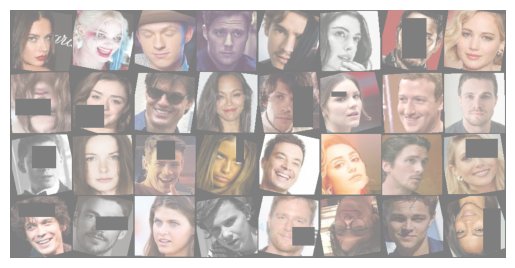

tensor(0) tensor(101) tensor(82) tensor(33)


In [24]:
#display random images from the dataset

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

In [25]:
with experiment.train():
    train(hyper_params['epochs'], model, criterion, optimizer, train_loader, val_loader, hyper_params['best_model_path'], device, experiment, save_at_end=True)

Begin training...


100%|██████████| 55/55 [00:25<00:00,  2.19it/s]


	Train Loss: 0.622 | Train Acc: 90.91%
Epoch: 02 | Epoch Time: 2m 38s
	 Val. Loss: 0.487 |  Val. Acc: 86.15%


100%|██████████| 55/55 [00:24<00:00,  2.22it/s]


	Train Loss: 0.450 | Train Acc: 90.91%
Epoch: 03 | Epoch Time: 2m 38s
	 Val. Loss: 0.399 |  Val. Acc: 89.40%


100%|██████████| 55/55 [00:24<00:00,  2.23it/s]


	Train Loss: 0.342 | Train Acc: 90.91%
Epoch: 04 | Epoch Time: 2m 35s
	 Val. Loss: 0.421 |  Val. Acc: 88.83%


100%|██████████| 55/55 [00:24<00:00,  2.20it/s]


	Train Loss: 1.567 | Train Acc: 63.64%
Epoch: 05 | Epoch Time: 2m 36s
	 Val. Loss: 0.419 |  Val. Acc: 88.14%


 56%|█████▋    | 248/439 [00:52<00:40,  4.73it/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/leo/Desktop/Thesis/env/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/leo/Desktop/Thesis/env/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/leo/Desktop/Thesis/env/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/leo/Desktop/Thesis/env/lib/python3.9/site-packages/torch/utils/data/dataset.py", line 295, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/Users/leo/Desktop/Thesis/env/lib/python3.9/site-packages/torchvision/datasets/folder.py", line 229, in __getitem__
    sample = self.loader(path)
  File "/Users/leo/Desktop/Thesis/env/lib/python3.9/site-packages/torchvision/datasets/folder.py", line 268, in default_loader
    return pil_loader(path)
  File "/Users/leo/Desktop/Thesis/env/lib/python3.9/site-packages/torchvision/datasets/folder.py", line 246, in pil_loader
    with open(path, "rb") as f:
FileNotFoundError: [Errno 2] No such file or directory: '../data/celebs_105/pins_Johnny Depp/Johnny Depp116_1780.jpg'


In [ ]:
with experiment.test():

    model.load_state_dict(torch.load(hyper_params['best_model_path']))

    test_loss, test_acc = evaluate(model, test_loader, criterion, device, experiment)

    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

100%|██████████| 110/110 [00:48<00:00,  2.28it/s]

Test Loss: 0.546 | Test Acc: 84.87%


In [ ]:
confusion(model, test_loader, device = device, experiment=experiment)

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/celebs-mobilenet/8225cd9a37c048da8f1efb54769b9732
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_acc [110]          : (0.7954545454545454, 76.39055024493825)
COMET INFO:     test_loss [110]         : (0.0031813979148864746, 0.9169747591018677)
COMET INFO:     train_acc [21950]       : (0.34375, 1.0)
COMET INFO:     train_loss [21950]      : (0.006767982617020607, inf)
COMET INFO:     train_step_time [21950] : (0, 20)
COMET INFO:     train_val_acc [50]      : (0.8198403648802737, 0.9167616875712656)
COMET INFO:     train_val_loss [50]     : (0.33918718695640565, 0.6589392028071663)
COMET INFO:   Parameters:
COMET INFO:     batch_size        : 32
COMET INFO:     best_model_path   : output/MN3L_Celeb50
COMET INFO: 